In [19]:
"""
Author: TMJ
Date: 2025-03-12 19:33:20
LastEditors: TMJ
LastEditTime: 2025-03-23 23:14:08
Description: 请填写简介
"""

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold

from dative_chemprop.models.DativeCGR import DativeCGR
from dative_chemprop.predictor import FengMichaelPredictor
from dative_chemprop.utils import ddG2ee

plt.rcParams["font.family"] = "Arial"
torch.set_float32_matmul_precision("high")
chemprop_dir = Path.cwd()
input_path = chemprop_dir / "data" / "ML_data_with_pesudo_state.csv"
dataset = pd.read_csv(input_path, index_col=0)

rxn_smiles_columns = [
    "rxn_smiles",
    "rxn_active_smiles",
    "dative_rxn_smiles",
    "dative_active_rxn_smiles",
]
target_columns = ["ddG (kcal/mol)"]

random_seed = 42
dataset

,rxn_smiles,ddG (kcal/mol),ee (%),acceptor_smiles,donor_smiles,donor_active_smiles,reactants_couples_smiles,reactants_active_couples_smiles,additives_smiles,solvents_smiles,...,dative_active_rxn_smiles,pure_rxn_smiles,pure_active_rxn_smiles,rxn_active_smiles,Ref.(DOI),temperature (C),pesudo_active_donor_rxn_smiles,donor_smiles_pesudo_active,no_extra_dative_rxn_smiles,no_extra_dative_pesudo_active_donor_rxn_smiles
0,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.279682,95,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F.CCOC...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(cc1)C(F)(F)F.CCOC...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.063894,93,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl.CCOC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc(c(c1)Cl)Cl.CCOC(=...,CCN(CC)CC,ClCCl,...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
2,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,1.832202,90,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2.CCOC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccc2c(c1)cccc2.CCOC(=...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
3,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.163032,94,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br.CCOC(=O)CC(=...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1Br.CCOC(=O)C=C(...,CCN(CC)CC,ClCCl,...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,Cc1nn([C:7](=[O:8])/[CH:19]=[CH:20]/[c:21]2[cH...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
4,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,2.421718,96,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1,CCOC(=O)CC(=O)NCc1ccccc1,CCOC(=O)C=C([O-])NCC1=CC=CC=C1,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1.CCOC(=O)CC(=O)...,Cc1nn(c(c1)C)C(=O)/C=C/c1ccccc1.CCOC(=O)C=C([O...,CCN(CC)CC,ClCCl,...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,10.1002/chem.201603056,40,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,[CH2-]COC(=O)CC(=O)NCC1=CC=CC=C1,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...,Cc1nn([C:17](=[O:18])/[CH:19]=[CH:20]/[c:21]2[...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,[O:8]=[C:7]1/[C:6](=[CH:5]/[c:23]2[cH:24][cH:2...,2.24328

In [ ]:
batch_size = 128
train_smis = dataset[rxn_smiles_columns].values
train_y = dataset[target_columns].values
base_model = DativeCGR(
    model_name=f"augmented_base_model",
    seed=random_seed,
)
if not os.path.exists(base_model.model_path):
    base_model.fit(
        train_smis.flatten(),
        train_y.repeat(len(rxn_smiles_columns), axis=0),
        batch_size=batch_size,
        num_workers=16,
        max_epochs=600,
    )

Loaded model from .checkpoints/hybrid_base_model_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

In [ ]:
from skfp.distances import dice_count_similarity, tanimoto_count_similarity
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from skfp.fingerprints import ECFPFingerprint

fpgen = ECFPFingerprint(radius=3, fp_size=2048, count=True)
finetune_model = DativeCGR(
    model_name=f"augmented_weighted_tuned_model",
    seed=base_model.seed,
)
target_acceptor = "Cc1cc(C)n(C(/C=C/c2ccccc2)=O)n1"
target_donor = "COC(CS)=O"
target_product = "COC(CSC(CC(n1c(C)cc(C)n1)=O)c2ccccc2)=O"
if not os.path.exists(finetune_model.model_path):
    finetune_model.load_from_checkpoint(base_model.model_path)
    weights = np.exp(
        -PAIRWISE_DISTANCE_FUNCTIONS["cosine"](
            np.concatenate(
                [
                    fpgen.transform(dataset["donor_smiles"]),
                    fpgen.transform(dataset["acceptor_smiles"]),
                ],
                axis=1,
            ),
            np.concatenate(
                [
                    fpgen.transform([target_donor]),
                    fpgen.transform([target_acceptor]),
                ],
                axis=1,
            ),
        )
    )
    finetune_model.fit(
        smis=train_smis.flatten(),
        y=(train_y * weights / weights.max()).repeat(len(rxn_smiles_columns), axis=0),
        freeze=False,
        batch_size=batch_size,
        num_workers=16,
        max_epochs=200,
    )

Loaded model from .checkpoints/hybrid_weighted_tuned_model_reac_prod.pt.


In [22]:
# predictor = FengMichaelPredictor.load(".checkpoints/exa_0519_cosine_reac_prod.pt")
predictor = FengMichaelPredictor.load(
    ".checkpoints/hybrid_weighted_tuned_model_reac_prod.pt"
)

Loaded model from /home/tmj/proj/NNdioxide-asymMichael/.checkpoints/hybrid_weighted_tuned_model_reac_prod.pt.


In [23]:
tuned_preds = predictor.predict_michael(
    acceptor="Cc1cc(C)n(C(/C=C/c2ccccc2)=O)n1",
    donor="COC(CS)=O",
    product="COC(CSC(CC(n1c(C)cc(C)n1)=O)c2ccccc2)=O",
    salt=[
        "[La+3].FC(S(=O)(=O)[O-1])(F)F.FC(S(=O)(=O)[O-1])(F)F.FC(S(=O)(=O)[O-1])(F)F",
        "[Yb+3].FC(S(=O)(=O)[O-1])(F)F.FC(S(=O)(=O)[O-1])(F)F.FC(S(=O)(=O)[O-1])(F)F",
    ],
    ligand=(
        dataset["ligands_smiles"]
        .value_counts()[dataset["ligands_smiles"].value_counts() > 35]
        .index
    ).values,
    solvent=(
        dataset["solvents_smiles"]
        .value_counts()[dataset["solvents_smiles"].value_counts() > 10]
        .index
    ).values,
    additive=(
        dataset["additives_smiles"]
        .value_counts()[dataset["additives_smiles"].value_counts() > 10]
        .index
    ).values,
    temperature=293,
    num_workers=10,
)

3957it [44:00,  1.50it/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 360/360 [00:12<00:00, 28.77it/s]


Text(0.5, 0, '')

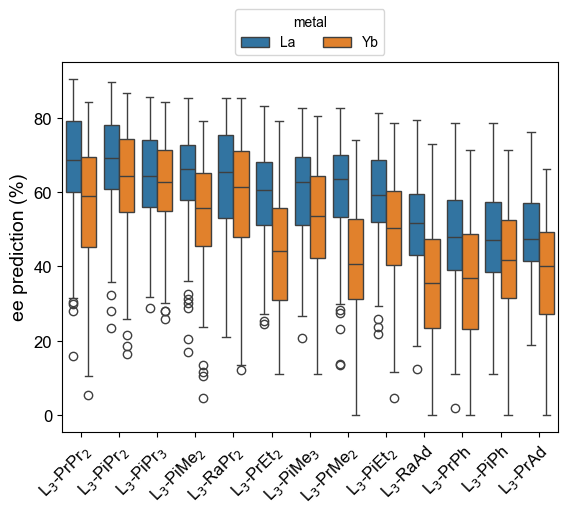

In [ ]:
import seaborn as sns


d = (
    tuned_preds.merge(
        dataset[["ligands_smiles", "Ligand Name"]]
        .drop_duplicates()
        .rename(columns={"ligands_smiles": "ligand"})
    )
    .merge(
        dataset[["catalysts_pre_smiles", "metal"]]
        .drop_duplicates()
        .rename(columns={"catalysts_pre_smiles": "salt"})
    )
    .sort_values("ee_estimation_mean", ascending=False)
)
d["ee_estimation_mean"] = d["ee_estimation_mean"] * 100
g = sns.boxplot(
    d,
    x="Ligand Name",
    y="ee_estimation_mean",
    hue="metal",
)
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=3)
for label in g.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
    label.set_rotation_mode("anchor")
    label.set_fontsize(12)
for label in g.get_yticklabels():
    label.set_fontsize(12)
g.set_ylabel("ee prediction (%)", fontsize=14)
g.set_xlabel("")

In [25]:
d = (
    tuned_preds.merge(
        dataset[["ligands_smiles", "Ligand Name"]]
        .drop_duplicates()
        .rename(columns={"ligands_smiles": "ligand"})
    )
    .merge(
        dataset[["catalysts_pre_smiles", "metal"]]
        .drop_duplicates()
        .rename(columns={"catalysts_pre_smiles": "salt"})
    )
    .groupby(["metal", "Ligand Name"])
    .agg({"ee_estimation_mean": ("std", "median")})
    .reset_index()
)
d.columns = ["Metal", "Ligand Name", "ee_estimation_std", "ee_estimation_median"]
d = d.sort_values("ee_estimation_median", ascending=False)
d["ee_estimation_median"] = d["ee_estimation_median"].apply(lambda x: x * 100)

In [26]:
d

,Metal,Ligand Name,ee_estimation_std,ee_estimation_median
4,La,L$_3$-PiPr$_2$,0.125234,69.078171
10,La,L$_3$-PrPr$_2$,0.143782,68.662089
1,La,L$_3$-PiMe$_2$,0.117107,66.310120
12,La,L$_3$-RaPr$_2$,0.145132,65.454549
17,Yb,L$_3$-PiPr$_2$,0.144370,64.403790
5,La,L$_3$-PiPr$_3$,0.119346,64.201343
8,La,L$_3$-PrMe$_2$,0.129451,63.588941
2,La,L$_3$-PiMe$_3$,0.127649,62.731284
18,Yb,L$_3$-PiPr$_3$,0.126707,62.647903
25,Yb,L$_3$-RaPr$_2$,0.158317,61.338222


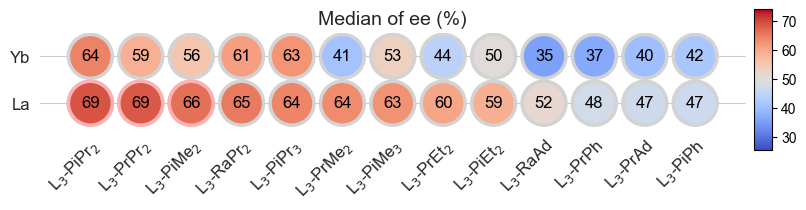

In [30]:
import matplotlib.cm as cm

norm = plt.Normalize(
    vmin=d["ee_estimation_median"].min() - 10,
    vmax=d["ee_estimation_median"].max() + 5,
)
with sns.axes_style("whitegrid"):
    g = sns.relplot(
        d,
        x="Ligand Name",
        y="Metal",
        hue="ee_estimation_median",
        hue_norm=norm,
        edgecolor="lightgray",
        palette="coolwarm",
        legend=False,
        s=1000,
        size_norm=(0, 0.2),
    )
    sns.scatterplot(
        d[d["ee_estimation_median"] > 66],
        x="Ligand Name",
        y="Metal",
        hue="ee_estimation_median",
        hue_norm=norm,
        edgecolor="#FCB2B2",
        palette="coolwarm",
        legend=False,
        s=1000,
        size_norm=(0, 0.2),
    )
    g.despine(left=True, bottom=True)
    g.ax.margins(0.2)
    g.ax.set_ylim(-0.5, 1.5)
    g.ax.set_xlim(-1, 13)
    for label in g.ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
        label.set_rotation_mode("anchor")
        label.set_fontsize(12)
        label.set_fontfamily("Arial")
    for label in g.ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontfamily("Arial")
ligand_to_index = {
    v: k
    for k, v in d["Ligand Name"]
    .drop_duplicates()
    .reset_index(drop=True)
    .to_dict()
    .items()
}
g.set_xlabels("")
g.set_ylabels("")
for i, (x, y, hue, size) in enumerate(
    zip(
        d["Ligand Name"],
        d["Metal"],
        d["ee_estimation_median"],
        d["ee_estimation_std"],
    )
):
    g.ax.text(
        ligand_to_index[x],
        {"La": 0, "Yb": 1}[y],
        f"{hue:.0f}",
        ha="center",
        va="center",
        color="black",
        fontfamily="Arial",
        fontsize=12,
    )
g.ax.set_title("Median of ee (%)", fontfamily="Arial", fontsize=14)
cmap = plt.get_cmap("coolwarm")
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
g.figure.colorbar(
    mappable,
    ax=g.ax,
    use_gridspec=True,
    location="right",
    pad=0.01,
    shrink=1.5,
    aspect=8,
)
g.figure.set_size_inches(9, 2.5)
plt.tight_layout()
g.figure.savefig("img/ee_estimation.png", dpi=300)